In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch
import csv
from matplotlib.font_manager import FontProperties

In [2]:
header_rows = 0
transmission_uc_data = pd.read_csv('data/24.12会议/couple/under couple_arcf10.0_setv71.263_actw1549.5246.csv_.csv', skiprows=header_rows, nrows=None)
transmission_cc_data = pd.read_csv('data/24.12会议/couple/critical couple_arcf10.0_setv71.263_actw1549.5251.csv_.csv', skiprows=header_rows, nrows=None)
transmission_oc_data = pd.read_csv('data/24.12会议/couple/overcouple_arcf10.0_setv71.263_actw1549.5251.csv_.csv', skiprows=header_rows, nrows=None)

In [3]:
power_uc = transmission_uc_data['Channel 2']
power_cc = transmission_cc_data['Channel 2']
power_oc = transmission_oc_data['Channel 2']
time_uc = transmission_uc_data['Time']

# 平滑处理
power_uc = power_uc.rolling(window=300).mean()
power_cc = power_cc.rolling(window=300).mean()
power_oc = power_oc.rolling(window=300).mean()

# 以power_uc最低值的时间为基准，将时间轴平移
time_uc = time_uc - time_uc[power_uc.idxmin()]

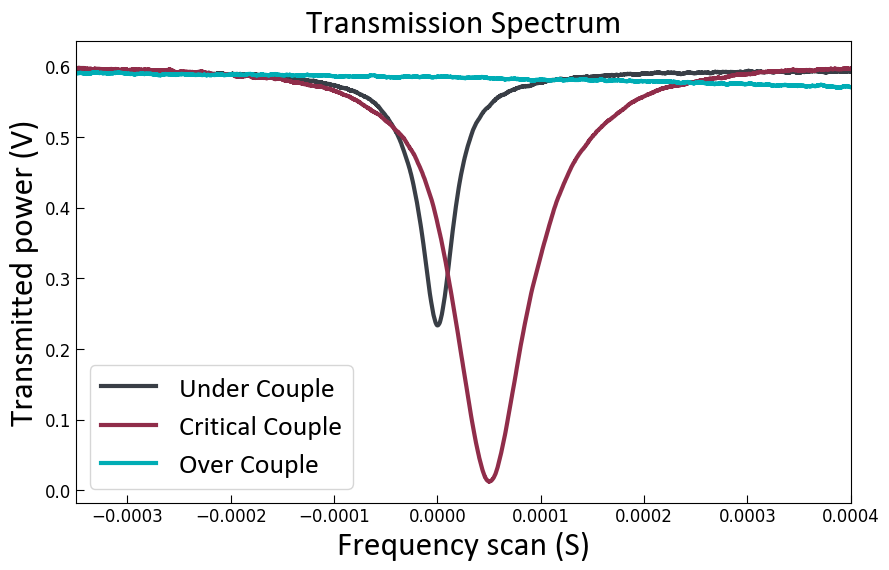

In [15]:
# 绘制光谱图
plt.figure(figsize=(10, 6))
# 绘制曲线
plt.plot(time_uc, power_uc, color='#393e46ff', linestyle='-', lw=3, label='Under Couple')
plt.plot(time_uc+0.00025, power_cc, color='#902d4aff', linestyle='-', lw=3, label='Critical Couple')
plt.plot(time_uc+0.0052, power_oc, color='#00adb5ff', linestyle='-', lw=3, label='Over Couple')
# 设置坐标轴范围、标签、标题、图例、网格等
plt.xlim(-0.00035, 0.0004) # 设置x轴范围 窄透射谱
# plt.xlim(-0.001, 0.005) # 设置x轴范围 宽透射谱
# plt.ylim(-70, 0) # 设置y轴范围

# 设置字体和字体大小
title_font = {'family': 'calibri', 'color':  'black', 'weight': 'normal', 'size': 24}
label_font = {'family': 'calibri', 'color':  'black', 'weight': 'normal', 'size': 24}
tick_font = {'family': 'calibri', 'color':  'black', 'weight': 'normal', 'size': 20}
# 设置图例字体
legend_font = FontProperties(family='calibri', weight='normal', size=20)
# 设置刻度字体
plt.tick_params(axis='both', labelsize=12)  # 刻度字体大小

# 设置刻度线向内
plt.tick_params(axis='both', direction='in', length=6)  # 轴 'both' 表示x轴和y轴都应用此设置，direction='in' 表示刻度线向内，length=6 设置刻度线长度

plt.xlabel('Frequency scan (S)', fontdict=label_font)
plt.ylabel('Transmitted power (V)', fontdict=label_font)
plt.title('Transmission Spectrum', fontdict=title_font)
plt.legend(prop=legend_font)
# plt.grid(True)
# 导出为矢量图格式（SVG 或 PDF），确保高质量
plt.savefig('data/24.12会议/couple/透射谱窄.svg', format='svg', dpi=300)  # 可选择 'pdf' 或 'svg' 等格式
plt.show()